<a href="https://colab.research.google.com/github/kunalburgul/Templates_for_Hackathons/blob/main/V_1_BC_ILP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **V_1-BC-ILP --> Version 1 - Binary Classification - Insurance Lead Prediction**

## **Problem Statement**

### **Health Insurance Lead Prediction**

Your Client FinMan is a financial services company that provides various financial services like loan, investment funds, insurance etc. to its customers. FinMan wishes to cross-sell health insurance to the existing customers who may or may not hold insurance policies with the company. The company recommend health insurance to it's customers based on their profile once these customers land on the website. Customers might browse the recommended health insurance policy and consequently fill up a form to apply. When these customers fill-up the form, their Response towards the policy is considered positive and they are classified as a lead.

Once these leads are acquired, the sales advisors approach them to convert and thus the company can sell proposed health insurance to these leads in a more efficient manner.

Now the company needs your help in building a model to predict whether the person will be interested in their proposed Health plan/policy given the information about:

- Demographics (city, age, region etc.)

- Information regarding holding policies of the customer

- Recommended Policy Information

### **Data Dictionary**

**Train Data**


| **Variable**  | **Definition** | 
|:-------------|:--------------|
|ID	|Unique Identifier for a row |
|City_Code	| Code for the City of the customers|
|Region_Code |	Code for the Region of the customers |
|Accomodation_Type | Customer Owns or Rents the house |
|Reco_Insurance_Type |	Joint or Individual type for the recommended insurance  |  
|Upper_Age	| Maximum age of the customer | 
|Lower _Age |	Minimum age of the customer |
|Is_Spouse	| If the customers are married to each other (in case of joint insurance) | 
| Health_Indicator | Encoded values for health of the customer |
|Holding_Policy_Duration | Duration (in years) of holding policy (a policy that customer has already subscribed to with the company) |
|Holding_Policy_Type | Type of holding policy |
|Reco_Policy_Cat | Encoded value for recommended health insurance |
|Reco_Policy_Premium | Annual Premium (INR) for the recommended health insurance |
|Response  | (Target)	0 : Customer did not show interest in the recommended policy,  1 : Customer showed interest in the recommended policy :|

### **Installing Dependencies**

In [ ]:
!pip3 install catboost

     |████████████████████████████████| 65.7MB 68kB/s 


### **Iniatlization**

In [ ]:
# Loading Libraries

# Warning Librarires
import warnings 
warnings.filterwarnings("ignore")

# Scientific and Data Manipulation Libraries 
import os
import math
import numpy as np
import pandas as pd 

# Data Visualization Libraries :
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px

# ML Libraries
from sklearn.impute            import KNNImputer
from sklearn.preprocessing     import LabelEncoder, OneHotEncoder 
from sklearn.preprocessing     import StandardScaler, MinMaxScaler, Normalizer, RobustScaler, MaxAbsScaler
from sklearn.model_selection   import KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn.tree              import DecisionTreeClassifier
from sklearn.ensemble          import VotingClassifier, RandomForestClassifier
from sklearn.metrics           import f1_score, confusion_matrix, classification_report

# Boosting Algorithms :
from xgboost                          import XGBClassifier
from catboost                         import CatBoostClassifier
from lightgbm                         import LGBMClassifier

## **Load Data**

In [ ]:
%%capture
# Loading Data
!gdown --id 1CNp7HMjDrn4L9VBltDA6DDG0uOZqa_mw --output train.csv
!gdown --id 1pCjff6qcr0ORoqJ0z_CRfz6oTxwUCp0c --output test.csv
# 
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [ ]:
# .head() will display the first 5 rows in the dataframe
train_data.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [ ]:
train_data.iloc[1]

ID                             2
City_Code                     C5
Region_Code                 1117
Accomodation_Type          Owned
Reco_Insurance_Type        Joint
Upper_Age                     75
Lower_Age                     22
Is_Spouse                     No
Health Indicator              X2
Holding_Policy_Duration      NaN
Holding_Policy_Type          NaN
Reco_Policy_Cat               22
Reco_Policy_Premium        30510
Response                       0
Name: 1, dtype: object

In [ ]:
test_data.head(5)

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
0,50883,C1,156,Owned,Individual,30,30,No,NaN,6.0,3.0,5,11934.0
1,50884,C4,7,Owned,Joint,69,68,Yes,X1,3.0,3.0,18,32204.8
2,50885,C1,564,Rented,Individual,28,28,No,X3,2.0,4.0,17,9240.0
3,50886,C3,1177,Rented,Individual,23,23,No,X3,3.0,3.0,18,9086.0
4,50887,C1,951,Owned,Individual,75,75,No,X3,NaN,NaN,5,22534.0


### **Performing EDA**

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  int64  
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         39191 non-null  object 
 9   Holding_Policy_Duration  30631 non-null  object 
 10  Holding_Policy_Type      30631 non-null  float64
 11  Reco_Policy_Cat          50882 non-null  int64  
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
dtypes: float64(2), int64(6

In [ ]:
train_data.describe()

,ID,Region_Code,Upper_Age,Lower_Age,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
count,50882.000000,50882.000000,50882.000000,50882.000000,30631.000000,50882.000000,50882.000000,50882.000000
mean,25441.500000,1732.788707,44.856275,42.738866,2.439228,15.115188,14183.950069,0.239947
std,14688.512535,1424.081652,17.310271,17.319375,1.025923,6.340663,6590.074873,0.427055
min,1.000000,1.000000,18.000000,16.000000,1.000000,1.000000,2280.000000,0.000000
25%,12721.250000,523.000000,28.000000,27.000000,1.000000,12.000000,9248.000000,0.000000
50%,25441.500000,1391.000000,44.000000,40.000000,3.000000,17.000000,13178.000000,0.000000
75%,38161.750000,2667.000000,59.000000,57.000000,3.000000,20.000000,18096.000000,0.000000
max,50882.000000,6194.000000,75.000000,75.000000,4.000000,22.000000,43350.400000,1.000000


In [ ]:
# Renaming or replacing the values from the features.
train_data.rename(columns={"Health Indicator": 'Health_Indicator'},inplace=True)
train_data['Holding_Policy_Duration']= train_data['Holding_Policy_Duration'].replace({'14+':str(15.0)})

test_data.rename(columns={"Health Indicator": 'Health_Indicator'},inplace=True)
test_data['Holding_Policy_Duration']= test_data['Holding_Policy_Duration'].replace({'14+':str(15.0)})

#### **EDA(Exploritary Data Analysis) Functions**

In [ ]:
# Some intresting EDA Functions

# Function for detecting features with Null value count and Unique values count with datatype
def info_data(data):
    Null = pd.Series(data.isnull().sum())
    Unique_Count = pd.Series(data.describe(include='all',datetime_is_numeric=True).loc['unique', :])
    Data_type = pd.Series(data.dtypes)
    info_abt_data = pd.DataFrame(({"Null":Null, "Unique Count": Unique_Count, "Data type": Data_type}))
    print(data.shape)
    return info_abt_data

# Funciton for detecting categorical classification of value count and in percentage for the whole data
def info_cat_percent(feature):
    abt_cat_percet = pd.DataFrame({"Values Count":feature.value_counts(), "Percentage":((feature.value_counts(normalize=True))*100)})
    return abt_cat_percet

# Function for displaying unique value count and data from the features present in the data
def display_unique(data):
    for column in data.columns :
        print("No of Unique Values in "+column+" Column are : "+str(data[column].nunique()))
        print("Actual Unique Values in "+column+" Column are : \n"+str(data[column].sort_values(ascending=True,na_position='last').unique() ))
        print("--------------------------------------------------------------------------------")

# Plot function Displaying visually missing amount of categorical values from the data
def plot_missing_data(data):
    columns_with_null = data.columns[data.isna().sum() > 0]
    null_pct = (data[columns_with_null].isna().sum() / data.shape[0]).sort_values(ascending=False) * 100
    plt.figure(figsize=(8,6));
    sns.barplot(y = null_pct.index, x = null_pct, orient='h')
    plt.title('% Na values in dataframe by columns');

In [ ]:
info_cat_percent(train_data['Response']) 

,Values Count,Percentage
0,38673,76.005267
1,12209,23.994733


#### **Exploring the Data and its Features** 

In [ ]:
info_data(train_data)

(50882, 14)


,Null,Unique Count,Data type
ID,0,NaN,int64
City_Code,0,36,object
Region_Code,0,NaN,int64
Accomodation_Type,0,2,object
Reco_Insurance_Type,0,2,object
Upper_Age,0,NaN,int64
Lower_Age,0,NaN,int64
Is_Spouse,0,2,object
Health_Indicator,11691,9,object
Holding_Policy_Duration,20251,15,object


In [ ]:
info_data(test_data)

(21805, 13)


,Null,Unique Count,Data type
ID,0,NaN,int64
City_Code,0,36,object
Region_Code,0,NaN,int64
Accomodation_Type,0,2,object
Reco_Insurance_Type,0,2,object
Upper_Age,0,NaN,int64
Lower_Age,0,NaN,int64
Is_Spouse,0,2,object
Health_Indicator,5027,9,object
Holding_Policy_Duration,8603,15,object


- Here we will be using **display_unique** function to check the unique values and its data from the features in both train and the test data. 

- So that if there is any misscount in unique value from any of the features then that could be taken care in the future.

In [ ]:
display_unique(train_data)

No of Unique Values in ID Column are : 50882
Actual Unique Values in ID Column are : 
[    1     2     3 ... 50880 50881 50882]
--------------------------------------------------------------------------------
No of Unique Values in City_Code Column are : 36
Actual Unique Values in City_Code Column are : 
['C1' 'C10' 'C11' 'C12' 'C13' 'C14' 'C15' 'C16' 'C17' 'C18' 'C19' 'C2'
 'C20' 'C21' 'C22' 'C23' 'C24' 'C25' 'C26' 'C27' 'C28' 'C29' 'C3' 'C30'
 'C31' 'C32' 'C33' 'C34' 'C35' 'C36' 'C4' 'C5' 'C6' 'C7' 'C8' 'C9']
--------------------------------------------------------------------------------
No of Unique Values in Region_Code Column are : 5316
Actual Unique Values in Region_Code Column are : 
[   1    2    4 ... 6191 6193 6194]
--------------------------------------------------------------------------------
No of Unique Values in Accomodation_Type Column are : 2
Actual Unique Values in Accomodation_Type Column are : 
['Owned' 'Rented']
---------------------------------------------------

In [ ]:
display_unique(test_data)

No of Unique Values in ID Column are : 21805
Actual Unique Values in ID Column are : 
[50883 50884 50885 ... 72685 72686 72687]
--------------------------------------------------------------------------------
No of Unique Values in City_Code Column are : 36
Actual Unique Values in City_Code Column are : 
['C1' 'C10' 'C11' 'C12' 'C13' 'C14' 'C15' 'C16' 'C17' 'C18' 'C19' 'C2'
 'C20' 'C21' 'C22' 'C23' 'C24' 'C25' 'C26' 'C27' 'C28' 'C29' 'C3' 'C30'
 'C31' 'C32' 'C33' 'C34' 'C35' 'C36' 'C4' 'C5' 'C6' 'C7' 'C8' 'C9']
--------------------------------------------------------------------------------
No of Unique Values in Region_Code Column are : 4694
Actual Unique Values in Region_Code Column are : 
[   1    2    4 ... 6180 6184 6185]
--------------------------------------------------------------------------------
No of Unique Values in Accomodation_Type Column are : 2
Actual Unique Values in Accomodation_Type Column are : 
['Owned' 'Rented']
---------------------------------------------------

In [ ]:
# Exploring all the percentage of catgeorical values present in the null features
print("Health_Indicatorn\n",train_data.Health_Indicator.value_counts(normalize=True),\
      "\n-------------------------------------------\nHolding_Policy_Duration\n", train_data.Holding_Policy_Duration.value_counts(normalize=True),\
      "\n-------------------------------------------\nHolding_Policy_Type\n",train_data.Holding_Policy_Type.value_counts(normalize=True))

Health_Indicatorn
 X1    0.331964
X2    0.263632
X3    0.172540
X4    0.146539
X5    0.044066
X6    0.032661
X7    0.005001
X8    0.001990
X9    0.001608
Name: Health_Indicator, dtype: float64 
-------------------------------------------
Holding_Policy_Duration
 1.0     0.146877
15.0    0.141523
2.0     0.139075
3.0     0.117071
4.0     0.090464
5.0     0.077111
6.0     0.061833
7.0     0.053704
8.0     0.042963
9.0     0.036368
10.0    0.026542
11.0    0.017825
12.0    0.016748
13.0    0.016682
14.0    0.015213
Name: Holding_Policy_Duration, dtype: float64 
-------------------------------------------
Holding_Policy_Type
 3.0    0.433515
1.0    0.266821
2.0    0.163397
4.0    0.136267
Name: Holding_Policy_Type, dtype: float64


#### **Getting Correlation between the Features**

In [ ]:
train_data.corr()

,ID,Region_Code,Upper_Age,Lower_Age,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
ID,1.000000,-0.000465,-0.001725,0.001101,0.006649,-0.002235,-0.002350,0.005159
Region_Code,-0.000465,1.000000,-0.005649,-0.005928,0.011599,-0.065120,-0.010797,0.001121
Upper_Age,-0.001725,-0.005649,1.000000,0.921392,0.141890,0.025257,0.792689,0.002772
Lower_Age,0.001101,-0.005928,0.921392,1.000000,0.118028,0.021163,0.615739,-0.002099
Holding_Policy_Type,0.006649,0.011599,0.141890,0.118028,1.000000,0.079678,0.121342,0.009297
Reco_Policy_Cat,-0.002235,-0.065120,0.025257,0.021163,0.079678,1.000000,0.060989,0.114321
Reco_Policy_Premium,-0.002350,-0.010797,0.792689,0.615739,0.121342,0.060989,1.000000,0.007943
Response,0.005159,0.001121,0.002772,-0.002099,0.009297,0.114321,0.007943,1.000000


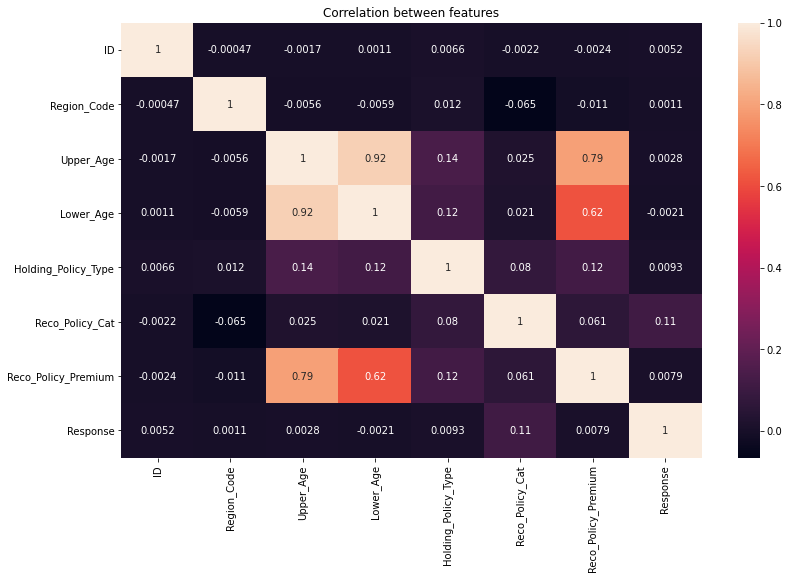

In [ ]:
plt.figure(figsize = (13, 8))
sns.heatmap(train_data.corr(), annot=True)
sns.cubehelix_palette(as_cmap=True)
plt.title('Correlation between features')
plt.show()

In [ ]:
# Removing the non-useful features from the data 
train_data.drop(['Region_Code'], axis=1,inplace=True)
test_data.drop(['Region_Code'], axis=1,inplace=True)

In [ ]:
# # Splitting the data into Input Data and Output Data
# X = train_data.drop(['Response'], axis=1)
# y = train_data['Response']
test_data.head()

,ID,City_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health_Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
0,50883,C1,Owned,Individual,30,30,No,NaN,6.0,3.0,5,11934.0
1,50884,C4,Owned,Joint,69,68,Yes,X1,3.0,3.0,18,32204.8
2,50885,C1,Rented,Individual,28,28,No,X3,2.0,4.0,17,9240.0
3,50886,C3,Rented,Individual,23,23,No,X3,3.0,3.0,18,9086.0
4,50887,C1,Owned,Individual,75,75,No,X3,NaN,NaN,5,22534.0


#### **Encoding - Converting the categorical text data to the numerical data**

In [ ]:
train_data['Health_Indicator']= train_data['Health_Indicator'].replace({'X1':8, 'X2':7, 'X3':6, 'X4':5, 'X5': 4, 'X6':2, 'X7':2 , 'X8':1, 'X9': 0 })
test_data['Health_Indicator']= test_data['Health_Indicator'].replace({'X1':8, 'X2':7, 'X3':6, 'X4':5, 'X5': 4, 'X6':2, 'X7':2 , 'X8':1, 'X9': 0 })                                                                      

In [ ]:
train_data_encoded = pd.get_dummies(train_data, columns=["City_Code", "Accomodation_Type",  "Reco_Insurance_Type", "Is_Spouse" ])
test_data_encoded = pd.get_dummies(test_data, columns=["City_Code", "Accomodation_Type",  "Reco_Insurance_Type", "Is_Spouse" ])

In [ ]:
train_data_encoded.head(10)

,ID,Upper_Age,Lower_Age,Health_Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,City_Code_C1,City_Code_C10,City_Code_C11,City_Code_C12,City_Code_C13,City_Code_C14,City_Code_C15,City_Code_C16,City_Code_C17,City_Code_C18,City_Code_C19,City_Code_C2,City_Code_C20,City_Code_C21,City_Code_C22,City_Code_C23,City_Code_C24,City_Code_C25,City_Code_C26,City_Code_C27,City_Code_C28,City_Code_C29,City_Code_C3,City_Code_C30,City_Code_C31,City_Code_C32,City_Code_C33,City_Code_C34,City_Code_C35,City_Code_C36,City_Code_C4,City_Code_C5,City_Code_C6,City_Code_C7,City_Code_C8,City_Code_C9,Accomodation_Type_Owned,Accomodation_Type_Rented,Reco_Insurance_Type_Individual,Reco_Insurance_Type_Joint,Is_Spouse_No,Is_Spouse_Yes
0,1,36,36,8.0,15.0,3.0,22,11628.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
1,2,75,22,7.0,NaN,NaN,22,30510.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0
2,3,32,32,NaN,1.0,1.0,19,7450.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0
3,4,52,48,8.0,15.0,3.0,19,17780.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0
4,5,44,44,7.0,3.0,1.0,16,10404.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0
5,6,52,52,7.0,5.0,1.0,22,15264.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0
6,7,28,28,NaN,NaN,NaN,17,10640.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
7,8,75,73,5.0,9.0,4.0,17,29344.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1
8,9,52,43,8.0,14.0,3.0,1,27283.2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0
9,10,59,26,NaN,7.0,4.0,18,21100.8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1


In [ ]:
test_data_encoded.head(10)

,ID,Upper_Age,Lower_Age,Health_Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,City_Code_C1,City_Code_C10,City_Code_C11,City_Code_C12,City_Code_C13,City_Code_C14,City_Code_C15,City_Code_C16,City_Code_C17,City_Code_C18,City_Code_C19,City_Code_C2,City_Code_C20,City_Code_C21,City_Code_C22,City_Code_C23,City_Code_C24,City_Code_C25,City_Code_C26,City_Code_C27,City_Code_C28,City_Code_C29,City_Code_C3,City_Code_C30,City_Code_C31,City_Code_C32,City_Code_C33,City_Code_C34,City_Code_C35,City_Code_C36,City_Code_C4,City_Code_C5,City_Code_C6,City_Code_C7,City_Code_C8,City_Code_C9,Accomodation_Type_Owned,Accomodation_Type_Rented,Reco_Insurance_Type_Individual,Reco_Insurance_Type_Joint,Is_Spouse_No,Is_Spouse_Yes
0,50883,30,30,NaN,6.0,3.0,5,11934.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
1,50884,69,68,8.0,3.0,3.0,18,32204.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1
2,50885,28,28,6.0,2.0,4.0,17,9240.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
3,50886,23,23,6.0,3.0,3.0,18,9086.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
4,50887,75,75,6.0,NaN,NaN,5,22534.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
5,50888,24,24,7.0,NaN,NaN,18,6150.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
6,50889,56,56,4.0,15.0,4.0,17,19152.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
7,50890,41,41,NaN,NaN,NaN,16,11034.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
8,50891,22,22,6.0,NaN,NaN,22,10784.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
9,50892,41,37,4.0,6.0,1.0,22,16934.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1


In [ ]:
train_data_encoded.shape

(50882, 51)

In [ ]:
test_data_encoded.shape

(21805, 50)

In [ ]:
y = train_data_encoded['Response']
train_data_encoded = train_data_encoded.drop(['Response'], axis=1)

#### **Dealing Missing Values**

![68uOdD2.png](https://i.imgur.com/68u0dD2.png)

Here we observing the data we will be observing the Advance Imputation techniques.

In [ ]:
train_knn = train_data_encoded.copy(deep=True)
test_knn = test_data_encoded.copy(deep=True)

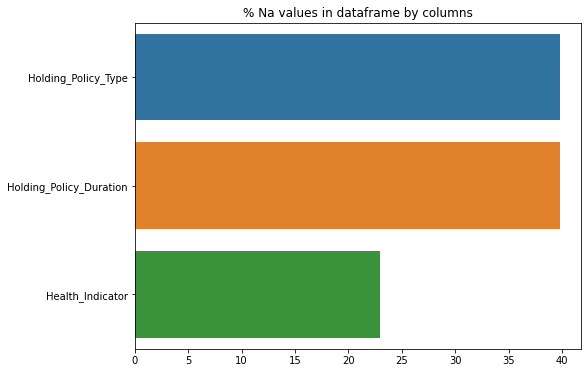

In [ ]:
plot_missing_data(train_knn)

In [ ]:
knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")
imputed = knn_imputer.fit_transform(train_knn)
df_imputed_train = pd.DataFrame(imputed, columns=train_knn.columns)

In [ ]:
knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")
imputed = knn_imputer.fit_transform(test_knn)
df_imputed_test = pd.DataFrame(imputed, columns=test_knn.columns)

In [ ]:
# df_imputedtrain.head(25)

In [ ]:
X_imputed_train = (df_imputed_train.drop(['ID'],axis=1)).astype(int)
X_imputed_test = (df_imputed_test.drop(['ID'],axis=1)).astype(int)

In [ ]:
X_train = X_imputed_train
y_train = y
X_test = X_imputed_test

### **Data Scaling : MinMaxScaler, StandardScaler, RobustScaler**

In [ ]:
def data_scaling( scaling_strategy , scaling_data , scaling_columns ):
    
    if    scaling_strategy =="RobustScaler" :
        scaling_data[scaling_columns] = RobustScaler().fit_transform(scaling_data[scaling_columns])
        
    elif  scaling_strategy =="StandardScaler" :
        scaling_data[scaling_columns] = StandardScaler().fit_transform(scaling_data[scaling_columns])
        
    elif  scaling_strategy =="MinMaxScaler" :
        scaling_data[scaling_columns] = MinMaxScaler().fit_transform(scaling_data[scaling_columns])
        
    elif  scaling_strategy =="MaxAbsScaler" :
        scaling_data[scaling_columns] = MaxAbsScaler().fit_transform(scaling_data[scaling_columns])
        
    else :  # If any other scaling send by mistake still perform Robust Scalar
        scaling_data[scaling_columns] = RobustScaler().fit_transform(scaling_data[scaling_columns])
    
    return scaling_data

In [ ]:
scaling_strategy = ["RobustScaler", "StandardScaler","MinMaxScaler","MaxAbsScaler"]
X_train_scale = data_scaling( scaling_strategy[1] , X_train , X_train.columns )
X_test_scale  = data_scaling( scaling_strategy [1] , X_test  , X_test.columns )

### **Create Baseline ML Model for Binary Classification Problem :**

In [ ]:
Classifiers = {'0._XGBoost' : XGBClassifier(learning_rate =0.1, n_estimators=494, max_depth=5,subsample = 0.70, verbosity = 0,
                                            scale_pos_weight = 2.5,updater ="grow_histmaker",base_score  = 0.2),
               
               '1.CatBoost' : CatBoostClassifier(learning_rate=0.15, n_estimators=494, subsample=0.085, 
                                                 max_depth=5, scale_pos_weight=2.5),
               
               '2.LightGBM' : LGBMClassifier(subsample_freq = 2, objective ="binary",importance_type = "gain",
                                             verbosity = -1, max_bin = 60,num_leaves = 300,
                                             boosting_type = 'dart',learning_rate=0.15, 
                                             n_estimators=494, max_depth=5, scale_pos_weight=2.5)
 }

print( list(Classifiers.keys()) )
print( list(Classifiers.values()) )

['0._XGBoost', '1.CatBoost', '2.LightGBM']
[XGBClassifier(base_score=0.2, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=494, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2.5, seed=None,
              silent=None, subsample=0.7, updater='grow_histmaker',
              verbosity=0), <catboost.core.CatBoostClassifier object at 0x7fe7ede679d0>, LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
               importance_type='gain', learning_rate=0.15, max_bin=60,
               max_depth=5, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=494, n_jobs=-1, num_leaves=300,
               objective='binary', random_state=None, reg_alpha=0.0,
        

### **Improve ML Model with Voting Classifier with MODEL Evaluation METRIC - "F1" and Predict Target "is_promoted"**

In [ ]:
ensemble_model_2 = VotingClassifier(estimators=[
                                              ('XGBoost_Best', list(Classifiers.values())[0]), 
                                              ('CatBoost_Best', list(Classifiers.values())[1]),
                                              ('LightGBM_Best', list(Classifiers.values())[2]),
                                             ], 
                                              voting='soft',weights=[5,5,5.2])

file_name = "SEED-294_AGAIN_RANK_4_ENSEMBLE_SOFT_5_5_5.2"
ensemble_model_2.fit(X_train_scale,y_train) 

Predicted_predictions_model_2 = ensemble_model_2.predict_proba( X_test_scale )[::,1]

0:	learn: 0.6819127	total: 76.6ms	remaining: 37.8s
1:	learn: 0.6753493	total: 98.1ms	remaining: 24.1s
2:	learn: 0.6726674	total: 119ms	remaining: 19.4s
3:	learn: 0.6708256	total: 139ms	remaining: 17s
4:	learn: 0.6687325	total: 159ms	remaining: 15.6s
5:	learn: 0.6674777	total: 180ms	remaining: 14.6s
6:	learn: 0.6657055	total: 197ms	remaining: 13.7s
7:	learn: 0.6645286	total: 213ms	remaining: 13s
8:	learn: 0.6639748	total: 230ms	remaining: 12.4s
9:	learn: 0.6632371	total: 250ms	remaining: 12.1s
10:	learn: 0.6629935	total: 270ms	remaining: 11.9s
11:	learn: 0.6621382	total: 297ms	remaining: 11.9s
12:	learn: 0.6607316	total: 317ms	remaining: 11.7s
13:	learn: 0.6606718	total: 338ms	remaining: 11.6s
14:	learn: 0.6596355	total: 354ms	remaining: 11.3s
15:	learn: 0.6585380	total: 374ms	remaining: 11.2s
16:	learn: 0.6574629	total: 391ms	remaining: 11s
17:	learn: 0.6574010	total: 407ms	remaining: 10.8s
18:	learn: 0.6568979	total: 428ms	remaining: 10.7s
19:	learn: 0.6566596	total: 448ms	remaining: 

### **Result Submission, Check Leaderboard & Improve "F1" Score :**

In [ ]:
predictions_2 = [int(round(value)) for value in Predicted_predictions_model_2]
Result_Promoted = pd.DataFrame({'ID': test_data["ID"], 'Response' : predictions_2})
pd.DataFrame(Result_Promoted).to_csv(file_name+".csv",index=False)